# Model Breakdown

In [1]:
import os
import torch
import torchaudio
from utils import load_model
import matplotlib.pyplot as plt
import numpy as np

In [2]:
audio_path_base = '/srv/data/Data/Sync Dataset/Data/Audio Files/Sync Segmented (Ethan)'
noise = 'Nil'
sample = '9_5.wav'

model_path = '/srv/data/Model/all1/model_best.pt'
model_config = '/srv/data/Model/all1/model.yaml'
device = torch.device('cpu')

In [3]:
# get signal
audio_path = os.path.join(audio_path_base, noise, sample)
mixture, fs = torchaudio.load(audio_path, normalize=True)
mixture = torch.unsqueeze(mixture, dim=0)

# get model
model = load_model(model_path, model_config, device)
model.eval()

# pass through encoder
input_frame_length = mixture.shape[2]     # save L for reconstruction later
x, num_pads = model._align_num_frames_with_strides(mixture)  # B, 1, T'
x, phase = model.encoder_forward(x)     # B, F, M
encoder_output = x.detach().numpy()

# pass through mask generator
x = model.mask_generator(x) * x.unsqueeze(1)  # B, S, F, M

decoder_input = x.detach().numpy()

In [4]:
# STFT output
feat_size = 512
kernel_size = 512
n_fft = 2*(feat_size-1)
transform = torchaudio.transforms.Spectrogram(n_fft=2*(feat_size-1),win_length=feat_size,power=None,)
x_stft = transform(torch.squeeze(mixture))
x_stft = torch.abs(x_stft)
encoder_stft_output = x_stft.detach().numpy().transpose()

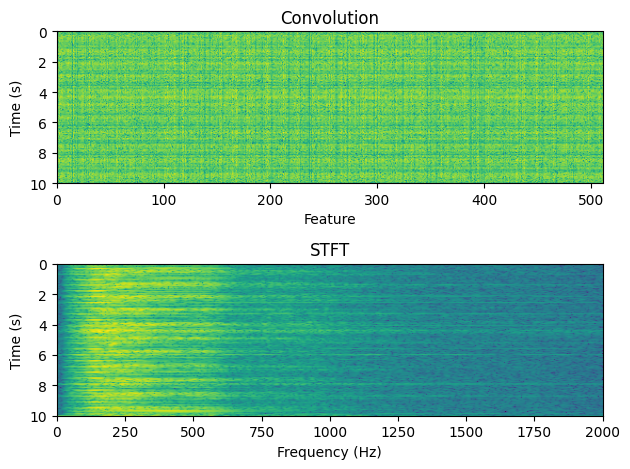

In [14]:
Z = encoder_output[0, :].transpose()
Z = np.log10(np.abs(Z))
# Z = np.abs(Z)
# Z = decoder_input[0, 0, :]

plt.subplot(2, 1, 1)
plt.imshow(Z, extent=[0,511,10,0], aspect='auto')
plt.title('Convolution')
plt.ylabel('Time (s)')
plt.xlabel('Feature')
# plt.colorbar()
# plt.yticks([])
# im.set_interpolation('bilinear')

Z = encoder_stft_output
Z = np.log10(np.abs(Z))
# Z = np.abs(Z)
plt.subplot(2, 1, 2)
plt.imshow(Z, extent=[0,2000,10,0], aspect='auto')
plt.title('STFT')
plt.ylabel('Time (s)')
plt.xlabel('Frequency (Hz)')
# plt.colorbar()
# plt.yticks([])


plt.tight_layout()
plt.show()